<a href="https://colab.research.google.com/github/yexf308/AdvancedMachineLearning/blob/main/Manifold_Learning_t_SNE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%pylab inline 
from IPython.display import Image
import numpy.linalg as LA
from time import time


Populating the interactive namespace from numpy and matplotlib


refer to [Summary1](https://distill.pub/2016/misread-tsne/), [Summary2](https://nlml.github.io/in-raw-numpy/in-raw-numpy-t-sne/) and  [Lectures](https://www.youtube.com/watch?v=NEaUSP4YerM).

$\def\m#1{\mathbf{#1}}$
$\def\mb#1{\mathbb{#1}}$
$\def\c#1{\mathcal{#1}}$

# t distributed Stochastic Neighborhood Embedding (t-SNE)
It is proposed by Laurens van der Maaten & Geoffrey Hinton in 2008. The main thing in t-SNE is it tends to **preserve local structure** at the same time preserving
the global structure as much as possible. It is like LE and LLE. 

## Stochastic Neighbor Embedding (SNE)
### Problem setup
<img src="https://github.com/yexf308/AdvancedMachineLearning/blob/main/image/tsne1.png?raw=true" width="200" />

**Naive projection:**

<img src="https://github.com/yexf308/AdvancedMachineLearning/blob/main/image/tsne2.png?raw=true" width="200" />
<img src="https://github.com/yexf308/AdvancedMachineLearning/blob/main/image/tsne3.png?raw=true" width="200" />


**Basic idea:** 
- Encode high dimensional neighborhood information as a distribution. 
- Intuition: Random walk between data points. High probability to jump to a close point. 

- Find low dimensional points such that their neighborhood distribution is similar.

- How do you measure distance between distributions: KL divergence!

Consider the neighborhood around an input data point $\m{x}^{(i)}\in \mb{R}^D$, imagine that we have a Gaussian distribution centered around $\m{x}^{(i)}$. Then the probability that $\m{x}^{(i)}$ chooses some other datapoint $\m{x}^{(j)}$ as its neighbor is in proportion with the density under this Gaussian. A point closer to $\m{x}^{(i)}$ will be more likely than one further away.

The $i\rightarrow j$ probability is the probability that
point $\m{x}^{(i)}$ chooses $\m{x}^{(j)}$ as its neighbor
\begin{align}
P_{j|i}=\frac{\exp(-\|\m{x}^{(i)} -\m{x}^{(j)}\|^2/2\sigma_i^2)}{\sum_{k\ne i}\exp(-\|\m{x}^{(i)} -\m{x}^{(k)}\|^2/2\sigma_i^2)}
\end{align}
with $P_{i|i}=0$. 

- The parameter $\sigma_i$ sets the size of the neighbor. 
  - Very low $\sigma_i$:  all the probability is in the nearest neighbor. 
  - Very high $\sigma_i$: Uniform weights. 

- Here we set $\sigma_i$ differently for each data point. 
Results depend heavily on $\sigma_i$, it defines the neighborhoods we are trying to preserve. 

<img src="https://github.com/yexf308/AdvancedMachineLearning/blob/main/image/tsne5.png?raw=true" width="300" />

<img src="https://github.com/yexf308/AdvancedMachineLearning/blob/main/image/tsne6.png?raw=true" width="600" />

This normalization is very important since $\sigma_i$ may be different at different locations.

<img src="https://github.com/yexf308/AdvancedMachineLearning/blob/main/image/tsne8.png?raw=true" width="600" />

### Cost function for SNE
**Goal:** Find good low dimensional embedding $\m{z}^{(i)}\in \mb{R}^d$.
For points $\m{z}^{(1)},\dots, \m{z}^{(N)}$, we define similarities in the low
dimensional space in an analogous way, 
\begin{align}
Q_{j|i}=\frac{\exp(-\|\m{z}^{(i)} -\m{z}^{(j)}\|^2)}{\sum_{k\ne i}\exp(-\|\m{z}^{(i)} -\m{z}^{(k)}\|^2)}
\end{align}
In this case, the variance is fixed to a constant 1; changing it would just rescale the learned map, and
not change its topology.

If the embedding is a good one, then $Q_{j|i}$ is very close to $P_{j|i}$. Therefore, SNE defines the objective
to be 
\begin{align}
L(\m{Z}) = \sum_i \mb{KL}(P_i||Q_i)= \sum_{i}\sum_j P_{j|i}\log\frac{P_{j|i}}{Q_{j|i}}
\end{align}
where $P_i$ is the conditional distribution over all other data points given $\m{x}^{(i)}$, $Q_i$ is the conditional distribution over all other latent points 
given $\m{z}^{(i)}$. 

The parameters for this objective function are $\m{z}^{(1)},\dots, \m{z}^{(N)}$. (one issue here is there is no embedding function, so cannot embed a new point). 



### KL divergence property 
- $\mb{KL}(P||Q)$  is the ”penalty” for using wrong distribution.

- $\mb{KL}(P||Q)\ge 0 $ and zero only when $Q=P$ almost surely.

- $\mb{KL}(P||Q)$ is a convex function. 

- If $Q_{ij}\approx 0$ but $Q_{ij}>0$, then $\mb{KL}(P||Q)$ will blow up to $\infty$. 

- KL divergence is not a metric function since it is not symmetric. 





### Optimize the objective

If we look at the gradient for each embedding vector(HW!), 
\begin{align}
\nabla_{\m{z}^{(i)}} L(\m{Z})= 2\sum_j (\m{z}^{(i)}-\m{z}^{(j)})(P_{j|i}-Q_{j|i}+P_{i|j}-Q_{i|j})
\end{align}
Thus points are pulled towards each other if the $P$’s are bigger than the $Q$’s, and repelled if the $Q$’s
are bigger than the $P$’s.

This objective function is not convex but can be minimized using SGD. Overall, it is not easy to optimize. 

<img src="https://github.com/yexf308/AdvancedMachineLearning/blob/main/image/tsne4.png?raw=true" width="300" />


<img src="https://github.com/yexf308/AdvancedMachineLearning/blob/main/image/tsne7.png?raw=true" width="600" />

## Symmetric SNE
This $\sigma_i$ makes whole thing asymmetric, we need to make things simpler here. We propose a symmetric version of SNE that minimizes a single KL between the joint distribution
$P$ in high dimensional space and $Q$ in low dimensional space. 
\begin{align}
L(\m{Z}) = \sum_i \mb{KL}(P||Q)= \sum_{i\ne j} P_{ij}\log\frac{P_{ij}}{Q_{ij}}
\end{align}
The obvious way to define $p_{ij}$ is to symmetrize $P_{i|j}$
\begin{align}
P_{ij} = \frac{P_{i|j}+P_{j|i}}{2N}
\end{align}
We can define $Q_{ij}$ similarly. The gradient becomes 
\begin{align}
\nabla_{\m{z}^{(i)}} L(\m{Z}) =4\sum_j (\m{z}^{(i)}-\m{z}^{(j)})(P_{ij}-Q_{ij})
\end{align}
It is slightly simplier but still non-convex. 

One issue for symmetric SNE is if $d=D$ (no embedding), the optimal embedding doesn't recover $\m{X}$, like the regular SNE does. 

## Crowding problem
- In high dimension we have more room, points can have a lot of different
neighbors. For example, it is possible to have 4 datapoints that are mutually equidistant in a 2-dimensional manifold (a square) but it is not possible to model this faithfully in a 1-dimensional map. Therefore, if the small distances can be modeled accurately in a map, most of the moderately distant datapoints will be too far away in the one-dimensional map. 

- In SNE, this will result in very small attractive force from datapoint $i$ to these too-distant map points. The very large number of such forces collapses together the points in the center of the map and prevents gaps from forming between the natural clusters. This is the ”crowding problem”: we don’t have enough room to
accommodate all neighbors.

- It is due to the use of
squared errors (or Gaussian probabilities).

- One solution to this is to change the Gaussian in $Q$ to a heavy tailed distribution. If $Q$ changes slower, we have more ”wiggle room” to place points at.

# t-SNE


- Student-t Probability density $p(x)\propto (1+\frac{x^2}{v})^{-(v+1)/2}$. For $v=1$, we get $p(x)\propto \frac{1}{1+x^2}$. So the distribution becomes equivalent to a Cauchy.  Probability goes to zero much slower then a Gaussian. 

<img src="https://github.com/yexf308/AdvancedMachineLearning/blob/main/image/tsne9.png?raw=true" width="400" />

- Refine $Q_{ij}$ as 
\begin{align}
Q_{ij}= \frac{(1+\|\m{z}^{(i)}-\m{z}^{(j)}\|^2)^{-1}}{\sum_{k\ne l} (1+\|\m{z}^{(k)}-\m{z}^{(l)}\|^2)^{-1}}
\end{align}

- We leave $P_{ij}$ as is. 



For t-SNE, the gradient turns out to be 
\begin{align}
\nabla_{\m{z}^{(i)}} L(\m{Z}) =4\sum_j (\m{z}^{(i)}-\m{z}^{(j)})(P_{ij}-Q_{ij})(1+\|\m{z}^{(i)}-\m{z}^{(j)}\|^2)^{-1}
\end{align}

We have the additional $(1+\|\m{z}^{(i)}-\m{z}^{(j)}\|^2)^{-1}$ compared with symmetric SNE. This term acts like an inverse square law.This means that points in embedding space act like stars and galaxies, forming many well-separated clusters (galaxies) each of
which has many stars tightly packed inside. This can be useful for separating different classes of data
in an unsupervised way, like handwritten digits. 

Both repulse close dissimilar points and attract far similar points, but the
t-SNE has a smaller attraction term to solve crowding.

<img src="https://github.com/yexf308/AdvancedMachineLearning/blob/main/image/tsne.png?raw=true" width="600" />

### Perplexity
We need to define an $N$-length vector containing each $\sigma_i$, but how do we get these $\sigma_i$? This is where **perplexity** comes into SNE.

For each distribution $P_{ij}$ (depends on $\sigma$), we define the **perplexity**. Different perplexity can capture different scales in the data.
- $\text{perp}(P_{i})=2^{H(P_{i})}$ with $H(P_i)=-\sum_j P_{j|i}\log_2(P_{j|i})$ is the entropy. 

- If $P$ is uniform over $k$ elements, perplexity is $k$.
  - Smooth version of $k$ in kNN.

  - Low perplexity = small $\sigma^2$.

  - High perplexity = large $\sigma^2$.

- Perplexity is a parameter that we set (usually between 5 and 50, sklearn chooses 30). We then set the $\sigma_i$’s such that for each row of $P$, the perplexity of that row is equal to our desired perplexity. 

- $\text{perp}(P_i)$ is a monotonically increasing function of $\sigma_i$, so we simply perform a binary search over each $\sigma_i$ until  $\text{perp}(P_i)=$ desired perplexity.

 


In [89]:
from google.colab import drive
drive.mount('/content/drive')
import os 
os.chdir("/content/drive/My Drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
def cal_pairwise_dist_sq(X):
  sum_x = sum(square(X), 1)
  dist_matrix_sq = add(add(-2 * dot(X, X.T), sum_x).T, sum_x)
  return dist_matrix_sq

def mysoftmax(X):
    """Compute softmax values for each row of matrix X 
         With the exception on the diagonal."""

    # Subtract max for numerical stability
    e_x = np.exp(X - np.max(X, axis=1).reshape([-1, 1]))
    np.fill_diagonal(e_x, 0.)

    # Add a tiny constant for stability of log we take later
    e_x = e_x + 1e-8  # numerical stability

    return e_x / e_x.sum(axis=1).reshape([-1, 1])

def calc_p_matrix(dist_matrix_sq, sigmas=None):
  """Convert a distances matrix to a matrix of p_{ij}=P_{j|i}."""
  if sigmas is not None:
      two_sig_sq = 2. * np.square(sigmas.reshape((-1, 1)))
      return mysoftmax(-dist_matrix_sq / two_sig_sq)
  else:
      return mysoftmax(-dist_matrix_sq)



In [3]:
def perplexity(dist_matrix_sq, sigmas=None):
  """Calculate the perplexity of each row
    of a matrix of probabilities."""
  p_matrix = calc_p_matrix(dist_matrix_sq, sigmas)
  entropy = -np.sum(p_matrix * np.log2(p_matrix), 1)
  perplexity = 2 ** entropy
  return perplexity


def binary_search(eval_fn, target, tol=1e-10, max_iter=10000,
                  lower=1e-20, upper=1000.):
  for i in range(max_iter):
    guess = (lower + upper) / 2.
    val = eval_fn(guess)
    if val > target:
      upper = guess
    else:
      lower = guess
    if np.abs(val - target) <= tol:
      break
  return guess

def find_optimal_sigmas(dist_matrix_sq, target_perplexity):
    """For each row of distances matrix, find sigma that results
    in target perplexity for that role."""
    sigmas = []
    # For each row of the matrix (each point in our dataset)
    for i in range(dist_matrix_sq.shape[0]):
        # Make fn that returns perplexity of this row given sigma
        eval_fn = lambda sigma: \
            perplexity(dist_matrix_sq[[i], :], np.array(sigma))
        # Binary search over sigmas to achieve target perplexity
        correct_sigma = binary_search(eval_fn, target_perplexity)
        # Append the resulting sigma to our output array
        sigmas.append(correct_sigma)
    return np.array(sigmas)

In [30]:
def symmetric_p(P):
  """Given conditional probabilities matrix P, return
    approximation of joint distribution probabilities."""
  return (P+P.T)/(2* P.shape[0])

def calc_q_sne(Z):
  """SNE: Given low-dimensional representations Z, compute
  matrix of joint probabilities with entries q_ij."""
  # Get the distances from every point to every other
  Z_dist_matrix_sq = cal_pairwise_dist_sq(Z)
  exp_distances = exp(-Z_dist_matrix_sq)
  np.fill_diagonal(exp_distances, 0.)
  return exp_distances / np.sum(exp_distances), None

def calc_p_sne(X, target_perplexity):
  """SNE: Given the data matrix X, compute
  matrix of joint probabilities with entries p_ij."""
  # Get the distances from every point to every other
  X_dist_matrix_sq = cal_pairwise_dist_sq(X)
  # Find optimal sigma for each row of this distances matrix
  sigmas = find_optimal_sigmas(X_dist_matrix_sq, target_perplexity)
  # Calculate the probabilities based on these optimal sigmas
  P_cond = calc_p_matrix(X_dist_matrix_sq, sigmas)
  P = symmetric_p(P_cond)
  return P, sigmas

def KL(P,Q):
    """
    Compute KL-divergence from matrix of high-dimensional probabilities 
    and coordinates of low-dimensional embeddings
    """
    P = P 
    Q = Q + 1e-8
    return sum(P * np.log(P) - P * np.log(Q))


def symmetric_sne_grad(P, Q, Z):
  """Estimate the gradient of the cost with respect to Z"""
  # This is a very smart way. 
  # 4 \sum_j (z_i-z_j)(P_{ij} - Q_{ij})
  pq_diff = P - Q  # NxN matrix
  pq_expanded = np.expand_dims(pq_diff, 2)  #NxNx1
  Z_diffs = np.expand_dims(Z, 1) - np.expand_dims(Z, 0)  # Nx1xN, 1xNxN
  grad = 4. * (pq_expanded * Z_diffs).sum(1)  #Nx2
  return grad

### 0. Load Data now 

In [90]:
from sklearn.datasets import load_digits
digits = load_digits() 

X = digits.data
y = digits.target 

X = X[(y==0) | (y==1) | (y==2) | (y==3)]
y = y[(y==0) | (y==1) | (y==2) | (y==3)]
n = X.shape[0]
print("\nThis data set contains " + str(n) + " samples")
print("\nDimensions of the  data set: ")
print(X.shape)


This data set contains 720 samples

Dimensions of the  data set: 
(720, 64)


### 1. Calculate pairwise distance
### 2. Calculate $\sigma_i$ and  Calculate $P$ matrix 



In [92]:
target_perplexity = 30;
t0= time()
P,sigmas = calc_p_sne(X, target_perplexity)
t1= time()
print("Calculating sigmas and P time: "+str(t1-t0))
print("\nMean sigma = " + str(np.mean(sigmas)))

Calculating sigmas and P time: 4.260108709335327

Mean sigma = 9.649178457361579


### 3. Running Gradient Descent optimization.
 

In [93]:
#it takes about 5mins
N_LOW_DIMS = 2
LEARNING_RATE = 20
MAX_ITER = 300
np.random.seed(12345)
# initialize the coordinates Z of the low-dimensional embedding 
#using Normal distribution and update Z via the Gradient Descent rule
Z = np.random.normal(loc = 0, scale = 1, size = (n, N_LOW_DIMS))
KL_array = []
file_names =[]
print("Running Gradient Descent: \n")

for i in range(MAX_ITER):
  Q, dist = calc_q_sne(Z)
  Z_grad  = symmetric_sne_grad(P, Q, Z)
  Z = Z - LEARNING_RATE * Z_grad

  plt.figure(figsize=(20,15))
  plt.scatter(Z[:,0], Z[:,1], c=y.astype(int), cmap = 'tab10', s = 50)
  plt.title("Symmetric SNE on MNIST", fontsize = 20)
  file_name = 'SNE_iter_' + str(i) + '.png'
  plt.xlim([-3.5,3.5])
  plt.ylim([-4,4])
  plt.savefig(file_name)
  plt.close()
  file_names.append(file_name)
  KL_curr = KL(P, Q)
  KL_array.append(KL_curr)
  if i % 10 == 0:
    print('At step '+ str(i) + ', KL divergence ='+ str(KL_curr))




Running Gradient Descent: 

At step 0, KL divergence =4.0930351366875355
At step 10, KL divergence =2.6264160311253595
At step 20, KL divergence =2.3931962759775627
At step 30, KL divergence =2.198647205058725
At step 40, KL divergence =1.9347173919775684
At step 50, KL divergence =1.6801504848664925
At step 60, KL divergence =1.4819140821942223
At step 70, KL divergence =1.3320402012486245
At step 80, KL divergence =1.2228462224698633
At step 90, KL divergence =1.143486648428323
At step 100, KL divergence =1.0822693833138575
At step 110, KL divergence =1.0322555066000276
At step 120, KL divergence =0.9909238460637485
At step 130, KL divergence =0.9569275957042129
At step 140, KL divergence =0.9288813149309955
At step 150, KL divergence =0.9055595972982956
At step 160, KL divergence =0.8860164191809604
At step 170, KL divergence =0.8694909084375385
At step 180, KL divergence =0.8553259178260147
At step 190, KL divergence =0.842992548517914
At step 200, KL divergence =0.8321555647755846

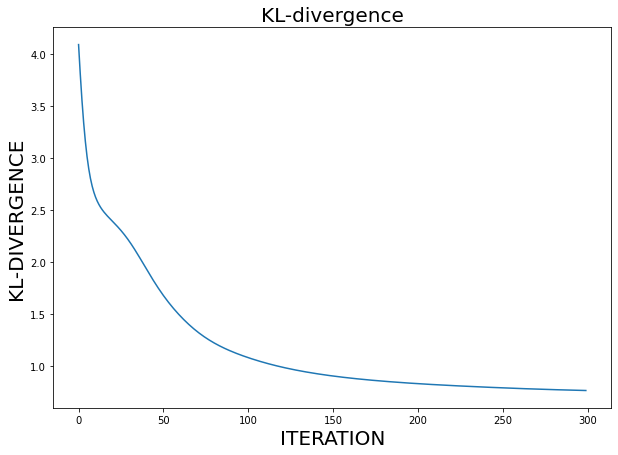

In [94]:
plt.figure(figsize=(10,7))
plt.plot(KL_array)
plt.title("KL-divergence", fontsize = 20)
plt.xlabel("ITERATION", fontsize = 20); plt.ylabel("KL-DIVERGENCE", fontsize = 20)
plt.show()

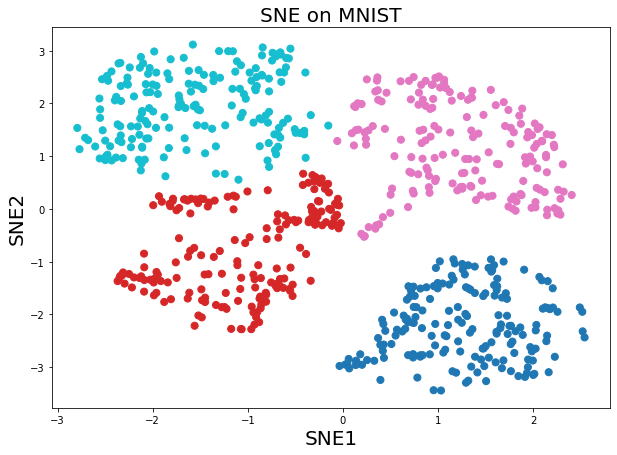

In [95]:
plt.figure(figsize=(10,7))
plt.scatter(Z[:,0], Z[:,1], c=y, cmap = 'tab10', s = 50)
plt.xlabel("SNE1", fontsize = 20); plt.ylabel("SNE2", fontsize = 20)
plt.title("SNE on MNIST", fontsize = 20)
plt.show()


In [96]:
import imageio
images = []
for file_name in file_names:
    images.append(imageio.imread(file_name))
imageio.mimsave('movie.gif', images)

## t-SNE


In [99]:
def calc_q_tsne(Z):
  """t-SNE: Given low-dimensional representations Y, compute
  matrix of joint probabilities with entries q_ij."""
  # q_{ij} = (1+\|z_i-z_j\|^2)^{-1} / (\sum_{k\ne l } (1+\|z_k - z_l\|^2)^{-1})
  Z_dist_matrix_sq = cal_pairwise_dist_sq(Z)
  inv_distances = (1+Z_dist_matrix_sq )**(-1) 
  np.fill_diagonal(inv_distances, 0.)
  return inv_distances / np.sum(inv_distances), inv_distances  

In [100]:
def tsne_grad(P, Q, Z, inv_distances):
    """Estimate the gradient of t-SNE cost with respect to Z."""
    #  4 \sum_j (z_i-z_j)(P_{ij} - Q_{ij}) * (1+\|z_i-z_j\|^2)^{-1}
    pq_diff = P - Q
    pq_expanded = np.expand_dims(pq_diff, 2)
    Z_diffs = np.expand_dims(Z, 1) - np.expand_dims(Z, 0)

    # Expand our inv_distances matrix so can multiply by y_diffs
    distances_expanded = np.expand_dims(inv_distances, 2)

    # Multiply this by inverse distances matrix
    Z_diffs_wt = Z_diffs * distances_expanded

    # Multiply then sum over j's
    grad = 4. * (pq_expanded * Z_diffs_wt).sum(1)
    return grad


In [110]:
#it takes about 5mins
N_LOW_DIMS = 2
LEARNING_RATE = 100
MAX_ITER = 400
np.random.seed(12345)
# initialize the coordinates Z of the low-dimensional embedding 
#using Normal distribution and update Z via the Gradient Descent rule
Z = np.random.normal(loc = 0, scale = 1, size = (n, N_LOW_DIMS))
KL_array = []
file_names =[]
print("Running Gradient Descent: \n")

for i in range(MAX_ITER):
  Q, inv_distances = calc_q_tsne(Z)
  Z_grad  = tsne_grad(P, Q, Z, inv_distances)
  Z = Z - LEARNING_RATE * Z_grad

  plt.figure(figsize=(20,15))
  plt.scatter(Z[:,0], Z[:,1], c=y.astype(int), cmap = 'tab10', s = 50)
  plt.title("t-SNE on MNIST", fontsize = 20)
  file_name = 't-SNE_iter_' + str(i) + '.png'
  plt.xlim([-8,8])
  plt.ylim([-8,8])
  plt.savefig(file_name)
  plt.close()
  file_names.append(file_name)
  KL_curr = KL(P, Q)
  KL_array.append(KL_curr)
  if i % 10 == 0:
    print('At step '+ str(i) + ', KL divergence ='+ str(KL_curr))




Running Gradient Descent: 

At step 0, KL divergence =2.7638204400383546
At step 10, KL divergence =2.5036330486029073
At step 20, KL divergence =2.1765502209143555
At step 30, KL divergence =1.8587169625869997
At step 40, KL divergence =1.6101473834347535
At step 50, KL divergence =1.445720336829637
At step 60, KL divergence =1.3337363890698941
At step 70, KL divergence =1.2432011172867847
At step 80, KL divergence =1.1714185045371226
At step 90, KL divergence =1.1112958127633739
At step 100, KL divergence =1.0636661989077236
At step 110, KL divergence =1.0245559766301946
At step 120, KL divergence =0.9911009923797303
At step 130, KL divergence =0.9621626184460889
At step 140, KL divergence =0.9364305947217458
At step 150, KL divergence =0.9129056277615519
At step 160, KL divergence =0.8912064741723347
At step 170, KL divergence =0.8717420277893458
At step 180, KL divergence =0.8543366517704581
At step 190, KL divergence =0.8378904956234452
At step 200, KL divergence =0.82266934648897

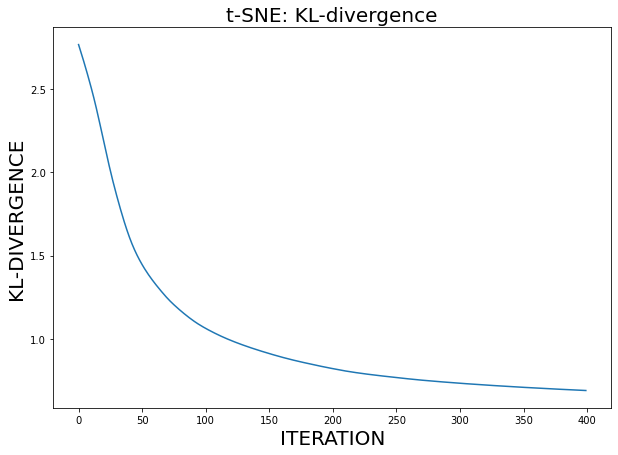

In [111]:
plt.figure(figsize=(10,7))
plt.plot(KL_array)
plt.title("t-SNE: KL-divergence", fontsize = 20)
plt.xlabel("ITERATION", fontsize = 20); plt.ylabel("KL-DIVERGENCE", fontsize = 20)
plt.show()

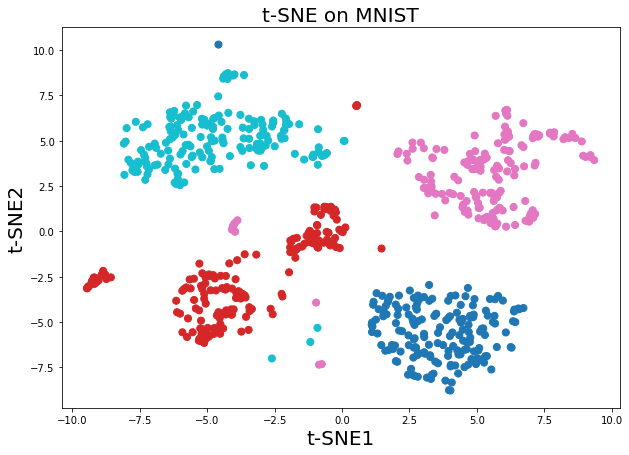

In [112]:
plt.figure(figsize=(10,7))
plt.scatter(Z[:,0], Z[:,1], c=y, cmap = 'tab10', s = 50)
plt.xlabel("t-SNE1", fontsize = 20); plt.ylabel("t-SNE2", fontsize = 20)
plt.title("t-SNE on MNIST", fontsize = 20)
plt.show()

In [113]:
import imageio
images = []
for file_name in file_names:
    images.append(imageio.imread(file_name))
imageio.mimsave('tsne-movie.gif', images)